In [1]:
from proc_handler import SeqClassHandler
import torch.nn as nn
import torch.nn.functional as F
from fastai.text import *
from pathlib import Path
import pandas as pd
import apex.optimizers.fused_lamb as LAMB
from functools import partial

In [579]:
seed = 42
bs = 10

In [580]:
# Initialise Processors (Tokenize and create Vocab)
model_name = 'distilbert-base-uncased'
processor = SeqClassHandler(model_name)

In [581]:
# repr
processor

Model: distilbert-base-uncased
Original Tokenizer: <transformers.tokenization_distilbert.DistilBertTokenizer object at 0x7f13f8023990>

In [582]:
# Split train/valid set from df
path = Path('./data')
data_name = 'IMDB Dataset.csv'
base_csv = pd.read_csv(path/data_name)
base_csv.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [583]:
# TextList and friends (TextDataBunch) require padding token id in the tokenizer vocabulary
tok_pad_idx = processor.pt_tokenizer.pad_token_id

In [584]:
# Load databunch from our DataFrame
data =  (TextList.from_df(base_csv, cols='review',processor=processor())
        .split_by_rand_pct(0.2,seed = seed)
        .label_from_df(cols= 'sentiment')
        .databunch(bs = bs, pad_first = False, pad_idx=tok_pad_idx))

In [585]:
data.train_ds[0]

(Text [CLS] one of the other reviewers has mentioned that after watching just 1 oz episode you ' ll be hooked . they are right , as this is exactly what happened with me . < br / > < br / > the first thing that struck me about oz was its brutality and un ##fl ##in ##ching scenes of violence , which set in right from the word go . trust me , this is not a show for the faint hearted or tim ##id . this show pulls no punches with regards to drugs , sex or violence . its is hardcore , in the classic use of the word . < br / > < br / > it is called oz as that is the nickname given to the oswald maximum security state pen ##ite ##nta ##ry . it focuses mainly on emerald city , an experimental section of the prison where all the cells have glass fronts and face inward ##s , so privacy is not high on the agenda . em city is home to many . . aryan ##s , muslims , gangs ##tas , latino ##s , christians , italians , irish and more . . . . so sc ##uf ##fles , death stares , dod ##gy dealings and shad

In [586]:
processor.model

CustTransformerModel(
  (pt_model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (dropout): Dropout(p=0.1, inplace=False)
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((

In [587]:
# learner initialise
lamb_opt = partial(LAMB.FusedLAMB) # set other inputs besides params
learner = Learner(data, model = processor.model, opt_func = lamb_opt, metrics = [accuracy, error_rate])

In [588]:
embedding_layer = learner.model.pt_model.distilbert.embeddings
encoder_blocks = learner.model.pt_model.distilbert.transformer.layer.children()
pre_classifier = learner.model.pt_model.pre_classifier
split_layers = [embedding_layer, *encoder_blocks, pre_classifier]

In [589]:
# split layer groups for gradual unfreeze
learner.split(split_layers)
len(learner.layer_groups)

8

In [590]:
# train
learner.save('untrain')

In [591]:
learner.load('untrain')

Learner(data=TextClasDataBunch;

Train: LabelList (40000 items)
x: TextList
[CLS] one of the other reviewers has mentioned that after watching just 1 oz episode you ' ll be hooked . they are right , as this is exactly what happened with me . < br / > < br / > the first thing that struck me about oz was its brutality and un ##fl ##in ##ching scenes of violence , which set in right from the word go . trust me , this is not a show for the faint hearted or tim ##id . this show pulls no punches with regards to drugs , sex or violence . its is hardcore , in the classic use of the word . < br / > < br / > it is called oz as that is the nickname given to the oswald maximum security state pen ##ite ##nta ##ry . it focuses mainly on emerald city , an experimental section of the prison where all the cells have glass fronts and face inward ##s , so privacy is not high on the agenda . em city is home to many . . aryan ##s , muslims , gangs ##tas , latino ##s , christians , italians , irish and more

In [592]:
# freeze to last layer group. all parameters past this group keep requires_grad = True
learner.freeze_to(-1) 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-01
Min loss divided by 10: 2.75E-03


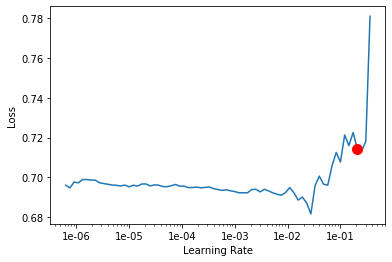

In [593]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [594]:
learner.fit_one_cycle(1,max_lr=1e-02)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.318150,0.326867,0.863400,0.136600,09:30


In [595]:
learner.save('run_1')

In [596]:
learner.freeze_to(-2)

In [597]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.75E-06
Min loss divided by 10: 7.59E-08


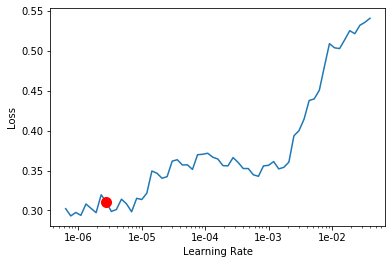

In [598]:
learner.recorder.plot(suggestion=True)

In [599]:
learner.fit_one_cycle(1,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.331895,0.263238,0.901700,0.098300,11:40


In [601]:
learner.save('run_2')